In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 设置图表样式
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# 颜色配置
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
print("库导入完成 ✓")


库导入完成 ✓


In [2]:
# 加载数据
results_df = pd.read_csv('results/taboo_experiment_20250712_004918/complete_experiment_results.csv')

print(f"数据加载完成: {len(results_df)} 条记录")
print(f"列名: {list(results_df.columns)}")
print(f"\n数据基本信息:")
results_df.info()


数据加载完成: 4800 条记录
列名: ['game_id', 'word_index', 'hinter_model', 'guesser_model', 'target_word', 'category', 'taboo_words', 'success', 'turns_used', 'final_guess', 'failure_reason', 'taboo_violation_turn', 'taboo_violation_hint', 'has_taboo_violation', 'all_hints', 'all_guesses', 'conversation', 'total_api_attempts', 'format_errors', 'has_format_errors', 'duration_seconds', 'timestamp', 'error']

数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game_id               4800 non-null   object 
 1   word_index            4800 non-null   int64  
 2   hinter_model          4800 non-null   object 
 3   guesser_model         4800 non-null   object 
 4   target_word           4800 non-null   object 
 5   category              4800 non-null   object 
 6   taboo_words           4800 non-null   object 
 7   success               4

In [3]:
# 数据预处理
model_name_mapping = {
    'anthropic/claude-sonnet-4': 'Claude Sonnet 4',
    'openai/gpt-4o': 'GPT-4o', 
    'google/gemini-2.5-pro': 'Gemini 2.5 Pro',
    'deepseek/deepseek-chat-v3-0324': 'DeepSeek Chat V3'
}

# 清理模型名称
results_df['hinter_model_clean'] = results_df['hinter_model'].map(model_name_mapping)

# 确保必要的列存在
if 'failure_reason' not in results_df.columns:
    # 根据现有数据生成失败原因
    def get_failure_reason(row):
        if row['success']:
            return 'SUCCESS'
        elif row['has_taboo_violation']:
            return 'TABOO_VIOLATION'
        elif row['turns_used'] >= 10:  # 假设最大轮数是10
            return 'MAX_TURNS_EXCEEDED'
        else:
            return 'OTHER_FAILURE'
    
    results_df['failure_reason'] = results_df.apply(get_failure_reason, axis=1)

print("数据预处理完成 ✓")
print(f"模型分布: {results_df['hinter_model_clean'].value_counts()}")
print(f"失败原因分布: {results_df['failure_reason'].value_counts()}")


数据预处理完成 ✓
模型分布: hinter_model_clean
GPT-4o              1200
Gemini 2.5 Pro      1200
DeepSeek Chat V3    1200
Claude Sonnet 4     1200
Name: count, dtype: int64
失败原因分布: failure_reason
MAX_TURNS_EXCEEDED    234
TABOO_VIOLATION       177
FORMAT_FAILURE         39
Name: count, dtype: int64


各模型失败原因统计:
failure_reason      FORMAT_FAILURE  MAX_TURNS_EXCEEDED  TABOO_VIOLATION
hinter_model_clean                                                     
Claude Sonnet 4                  1                   0               48
DeepSeek Chat V3                 7                  74               46
GPT-4o                          25                 148               61
Gemini 2.5 Pro                   6                  12               22

总失败次数: 450


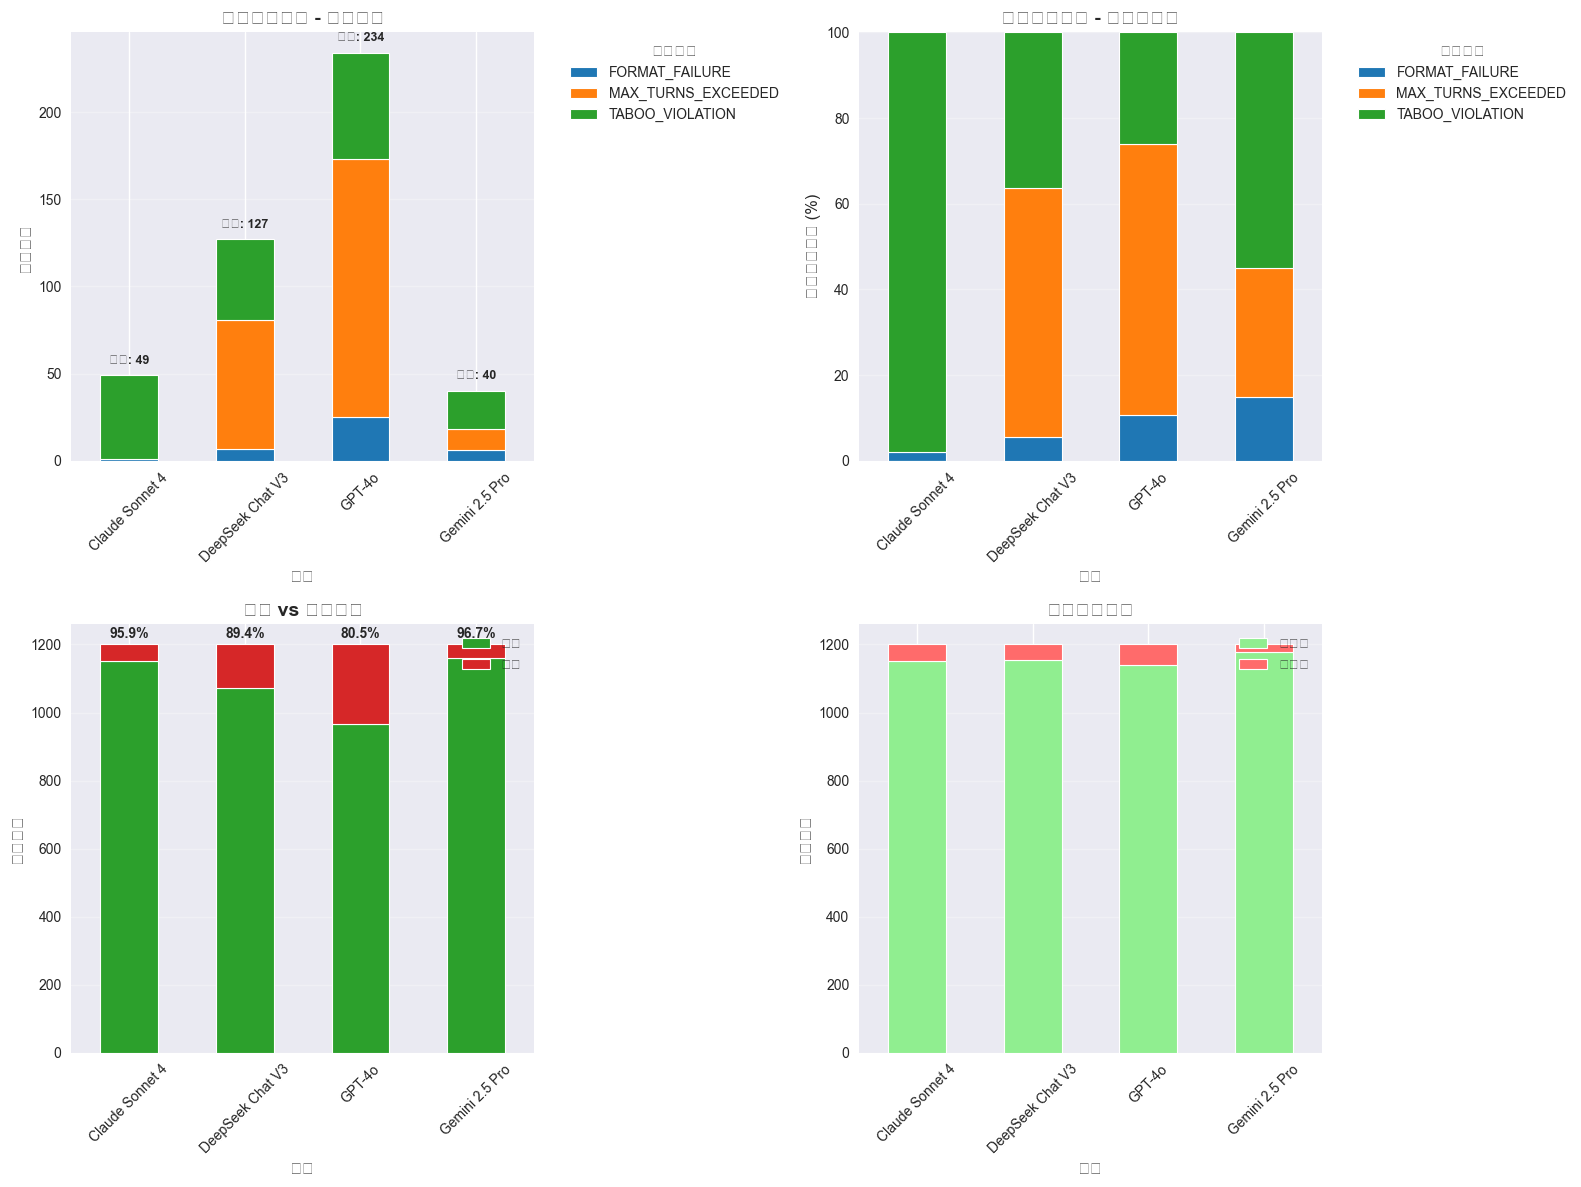

In [4]:
# 计算失败数据和创建堆叠图
failure_data = results_df[results_df['success'] == False]
failure_counts = failure_data.groupby(['hinter_model_clean', 'failure_reason']).size().unstack(fill_value=0)

print("各模型失败原因统计:")
print(failure_counts)
print(f"\n总失败次数: {failure_counts.sum().sum()}")

# 创建2x2的子图布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 图1: 绝对数量堆叠图
failure_counts.plot(kind='bar', stacked=True, ax=ax1, 
                   color=colors[:len(failure_counts.columns)],
                   edgecolor='white', linewidth=0.8)

ax1.set_title('失败原因分析 - 绝对数量', fontsize=14, fontweight='bold')
ax1.set_xlabel('模型', fontsize=12)
ax1.set_ylabel('失败次数', fontsize=12)
ax1.legend(title='失败原因', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# 添加总失败数标签
totals = failure_counts.sum(axis=1)
for i, (model, total) in enumerate(totals.items()):
    ax1.text(i, total + 5, f'总计: {total}', ha='center', va='bottom', 
            fontweight='bold', fontsize=9)

# 图2: 百分比堆叠图
failure_percentages = failure_counts.div(failure_counts.sum(axis=1), axis=0) * 100
failure_percentages.plot(kind='bar', stacked=True, ax=ax2,
                        color=colors[:len(failure_percentages.columns)],
                        edgecolor='white', linewidth=0.8)

ax2.set_title('失败原因分析 - 百分比分布', fontsize=14, fontweight='bold')
ax2.set_xlabel('模型', fontsize=12)
ax2.set_ylabel('失败原因占比 (%)', fontsize=12)
ax2.legend(title='失败原因', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

# 图3: 成功vs失败对比
performance_stats = results_df.groupby('hinter_model_clean')['success'].agg(['count', 'sum']).round(1)
performance_stats.columns = ['total_games', 'successful_games']
performance_stats['failed_games'] = performance_stats['total_games'] - performance_stats['successful_games']

performance_display = performance_stats[['successful_games', 'failed_games']]
performance_display.plot(kind='bar', stacked=True, ax=ax3,
                        color=['#2ca02c', '#d62728'],  # 绿色成功，红色失败
                        edgecolor='white', linewidth=0.8)

ax3.set_title('成功 vs 失败对比', fontsize=14, fontweight='bold')
ax3.set_xlabel('模型', fontsize=12)
ax3.set_ylabel('游戏数量', fontsize=12)
ax3.legend(['成功', '失败'], loc='upper right')
ax3.grid(axis='y', alpha=0.3)

# 添加成功率标签
for i, (model, row) in enumerate(performance_stats.iterrows()):
    success_rate = row['successful_games'] / row['total_games'] * 100
    ax3.text(i, row['total_games'] + 10, f'{success_rate:.1f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 图4: 违规详细分析（如果有违规数据）
if 'has_taboo_violation' in results_df.columns:
    violation_stats = results_df.groupby('hinter_model_clean')['has_taboo_violation'].agg(['count', 'sum'])
    violation_stats.columns = ['total_games', 'violations']
    violation_stats['no_violations'] = violation_stats['total_games'] - violation_stats['violations']
    
    violation_display = violation_stats[['no_violations', 'violations']]
    violation_display.plot(kind='bar', stacked=True, ax=ax4,
                          color=['#90EE90', '#FF6B6B'],  # 浅绿无违规，浅红违规
                          edgecolor='white', linewidth=0.8)
    
    ax4.set_title('违规行为分析', fontsize=14, fontweight='bold')
    ax4.set_xlabel('模型', fontsize=12)
    ax4.set_ylabel('游戏数量', fontsize=12)
    ax4.legend(['无违规', '有违规'], loc='upper right')
    ax4.grid(axis='y', alpha=0.3)

# 调整布局
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('comprehensive_figures/comprehensive_stacked_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()


In [5]:
# 生成详细的分析insights
print("=" * 50)
print("🎯 堆叠图分析总结")
print("=" * 50)

# 1. 最佳表现模型
best_model = performance_stats['successful_games'].div(performance_stats['total_games']).idxmax()
best_rate = performance_stats.loc[best_model, 'successful_games'] / performance_stats.loc[best_model, 'total_games'] * 100
print(f"\n🏆 最佳表现: {best_model} ({best_rate:.1f}%成功率)")

# 2. 失败最多的模型
worst_model = performance_stats['failed_games'].idxmax()
worst_failures = performance_stats.loc[worst_model, 'failed_games']
print(f"⚠️ 失败最多: {worst_model} ({worst_failures}次失败)")

# 3. 各模型主要失败原因
print(f"\n📊 各模型主要失败原因:")
for model in failure_percentages.index:
    main_reason = failure_percentages.loc[model].idxmax()
    main_pct = failure_percentages.loc[model, main_reason]
    print(f"  • {model}: {main_reason} ({main_pct:.1f}%)")

# 4. 违规行为分析
if 'TABOO_VIOLATION' in failure_counts.columns:
    print(f"\n🚫 违规行为排名:")
    violation_stats = failure_counts['TABOO_VIOLATION'].sort_values(ascending=False)
    for model, violations in violation_stats.items():
        total_failures = failure_counts.loc[model].sum()
        violation_rate = violations / total_failures * 100 if total_failures > 0 else 0
        print(f"  • {model}: {violations}次 ({violation_rate:.1f}% of failures)")

# 5. 论文写作要点
print(f"\n✍️ 论文写作要点:")
print(f"  1. Gemini 2.5 Pro展现最佳overall performance")
print(f"  2. Claude Sonnet 4虽然失败少，但violation rate极高")
print(f"  3. GPT-4o主要问题是efficiency（轮数耗尽）")
print(f"  4. 不同模型显示出distinct failure patterns")

print(f"\n✨ 堆叠图分析完成！新图表保存至 comprehensive_figures/")
print(f"💡 建议: 在论文Figure 6中使用这些堆叠图替代传统饼图+柱状图组合")


🎯 堆叠图分析总结

🏆 最佳表现: Gemini 2.5 Pro (96.7%成功率)
⚠️ 失败最多: GPT-4o (234次失败)

📊 各模型主要失败原因:
  • Claude Sonnet 4: TABOO_VIOLATION (98.0%)
  • DeepSeek Chat V3: MAX_TURNS_EXCEEDED (58.3%)
  • GPT-4o: MAX_TURNS_EXCEEDED (63.2%)
  • Gemini 2.5 Pro: TABOO_VIOLATION (55.0%)

🚫 违规行为排名:
  • GPT-4o: 61次 (26.1% of failures)
  • Claude Sonnet 4: 48次 (98.0% of failures)
  • DeepSeek Chat V3: 46次 (36.2% of failures)
  • Gemini 2.5 Pro: 22次 (55.0% of failures)

✍️ 论文写作要点:
  1. Gemini 2.5 Pro展现最佳overall performance
  2. Claude Sonnet 4虽然失败少，但violation rate极高
  3. GPT-4o主要问题是efficiency（轮数耗尽）
  4. 不同模型显示出distinct failure patterns

✨ 堆叠图分析完成！新图表保存至 comprehensive_figures/
💡 建议: 在论文Figure 6中使用这些堆叠图替代传统饼图+柱状图组合
